# nb-model_ret

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath, exists
from pathlib import Path
from functools import partial
import random
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_ret.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
from verification.batch_norm import BatchNormVerificationCallback
from verification.batch_gradient import BatchGradientVerificationCallback

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, load_json, dump_json, rectify_json, load_df, str_now, makedir_if_not_exists, is_valid, isnt, compose, pd_split_ternary_to_binary, df_del_midx_level, midx_intersect, pd_get_midx_level, pd_rows, df_midx_restack
from common_util import NestedDefaultDict
from model.common import EXP_LOG_DIR, EXP_PARAMS_DIR, ASSETS, DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TRAIN_RATIO, EXPECTED_NUM_HOURS
from model.pl_xgdm import XGDataModule
from model.pl_np import NPModel
from model.np_util2 import AttentiveNP
from recon.viz import *
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_ret.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

In [135]:
model_name = 'anp'
asset_name = ASSETS[3]
dsubs = 'h'
fdata_name = f'h_pba_{dsubs}' # hpomzug
ldata_name = 'ddir'
loss_type = 'clf-ce'
model_type = loss_type.split('-')[0]

# monitor = 'val_f1.0' if (model_type == 'clf') else 'val_mae'
monitor = 'val_accuracy' if (model_type == 'clf') else 'val_mae'
num_classes = 2 if (model_type == 'clf') else None

optimize_dir = {
    'val_loss': 'minimize',
    'val_mae': 'minimize',
    'val_mse': 'minimize'
}.get(monitor, 'maximize')

pl_model_fn, pt_model_fn = NPModel, AttentiveNP
model_name = f'{model_type}_{pl_model_fn.__name__}_{pt_model_fn.__name__}'
logging.getLogger("lightning").setLevel(logging.ERROR)
print('cuda status: {}'.format('✓' if (torch.cuda.is_available()) else '🞩'))

cuda status: ✓


## 4 Assets X {CNP, LNP, NP, X}

In [136]:
t_params = {
	"window_size": 10,
	"feat_dim": None,
	"train_shuffle": False,
	"epochs": 40,
	"batch_size": 256,
	"batch_step_size": 128,
	"train_resample": None,
	"train_target_overlap": 0,
	"train_sample_context_size": False,
	"context_size": 128,
	"target_size": 128,
	"loss": "clf-ce",
	"class_weights": None,
	"sample_out": False,
	"opt": {
		"name": "adam",
		"kwargs": {
			"lr": 0.0005
		}
	},
	"num_workers": 0,
	"pin_memory": True
}

In [137]:
fret=None
dm = XGDataModule(t_params, asset_name, fdata_name, ldata_name, interval=(2007, 2018), fret=None,
                  overwrite_cache=False)
dm.prepare_data()
dm.setup()

#mdl = pl_model_fn(pt_model_fn, m_params, t_params, dm.fobs)

In [138]:
ret_train = dm.raw['train'][2].sum(axis=-1).squeeze()
ret_train_neg_ = dm.raw['train'][2][:, :, 0].squeeze()
ret_train_neg = ret_train_neg_[ret_train_neg_ < 0]
ret_train_pos_ = dm.raw['train'][2][:, :, 1].squeeze()
ret_train_pos = ret_train_pos_[ret_train_pos_ > 0]

In [139]:
np.quantile(ret_train, .5)

0.000701532926726367

In [108]:
np.quantile(ret_train_pos, .1)

0.001040450384445002

In [58]:
np.quantile(ret_train_neg, .9)

-0.0009683850754771406

<BarContainer object of 50 artists>

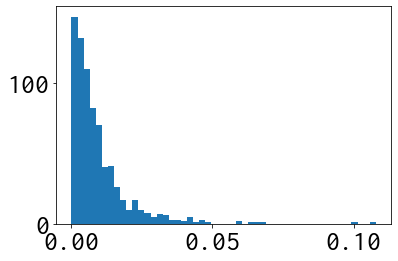

In [57]:
plt.hist(ret_train_pos, bins=50)[2]

<BarContainer object of 50 artists>

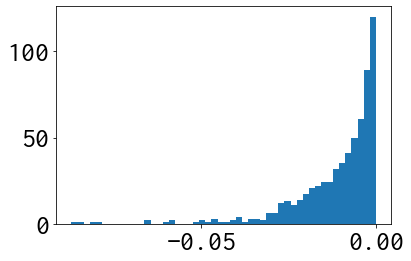

In [56]:
plt.hist(ret_train_neg, bins=50)[2]

In [12]:
#t_params

In [35]:
#mdl